In [275]:
import numpy as np
from skimage.morphology import erosion, dilation, binary_erosion, opening, closing, white_tophat, reconstruction, black_tophat, skeletonize, convex_hull_image, thin
from skimage.morphology import square, diamond, octagon, rectangle, star, disk
from skimage.filters.rank import entropy, enhance_contrast_percentile
from skimage.filters import threshold_otsu, threshold_local, rank, median
from PIL import Image
from scipy import ndimage as ndi
from skimage.util import img_as_ubyte
import math
from skimage import data, filters
from matplotlib import pyplot as plt
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
import sys
import copy
from google.colab import drive

In [276]:
drive.mount('/content/gdrive')
TD_DIR = 'gdrive/My Drive/MI206/'
sys.path.append(TD_DIR)
print(os.path.exists(TD_DIR))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
True


# FONCTIONS DE BASE

In [277]:
def my_segmentation(img, img_mask, seuil):
    img_out = (img_mask & (img < seuil))
    return img_out

def evaluate(img_out, img_GT):
    GT_skel  = thin(img_GT, max_iter = 15) # On suppose que la demie Ã©paisseur maximum 
    img_out_skel  = thin(img_out, max_iter = 15) # d'un vaisseau est de 15 pixels...
    TP = np.sum(img_out_skel & img_GT) # Vrais positifs
    FP = np.sum(img_out_skel & ~img_GT) # Faux positifs (relaxes)
    FN = np.sum(GT_skel & ~img_out) # Faux negatifs (relaxes)

    ACCU = TP / (TP + FP) # Precision
    RECALL = TP / (TP + FN) # Rappel
    return ACCU, RECALL, img_out_skel, GT_skel

In [278]:
#Ouvrir l'image originale en niveau de gris
img =  np.asarray(Image.open(TD_DIR + './images_IOSTAR/star28_ODN.jpg')).astype(np.uint8)
print(img.shape)

nrows, ncols = img.shape
row, col = np.ogrid[:nrows, :ncols]


(512, 512)


In [279]:
#On ne considere que les pixels dans le disque inscrit 
img_mask = (np.ones(img.shape)).astype(np.bool_)
invalid_pixels = ((row - nrows/2)**2 + (col - ncols/2)**2 > (nrows / 2)**2)
img_mask[invalid_pixels] = 0



Accuracy = 0.1334881528173072 , Recall = 0.7805799469062692


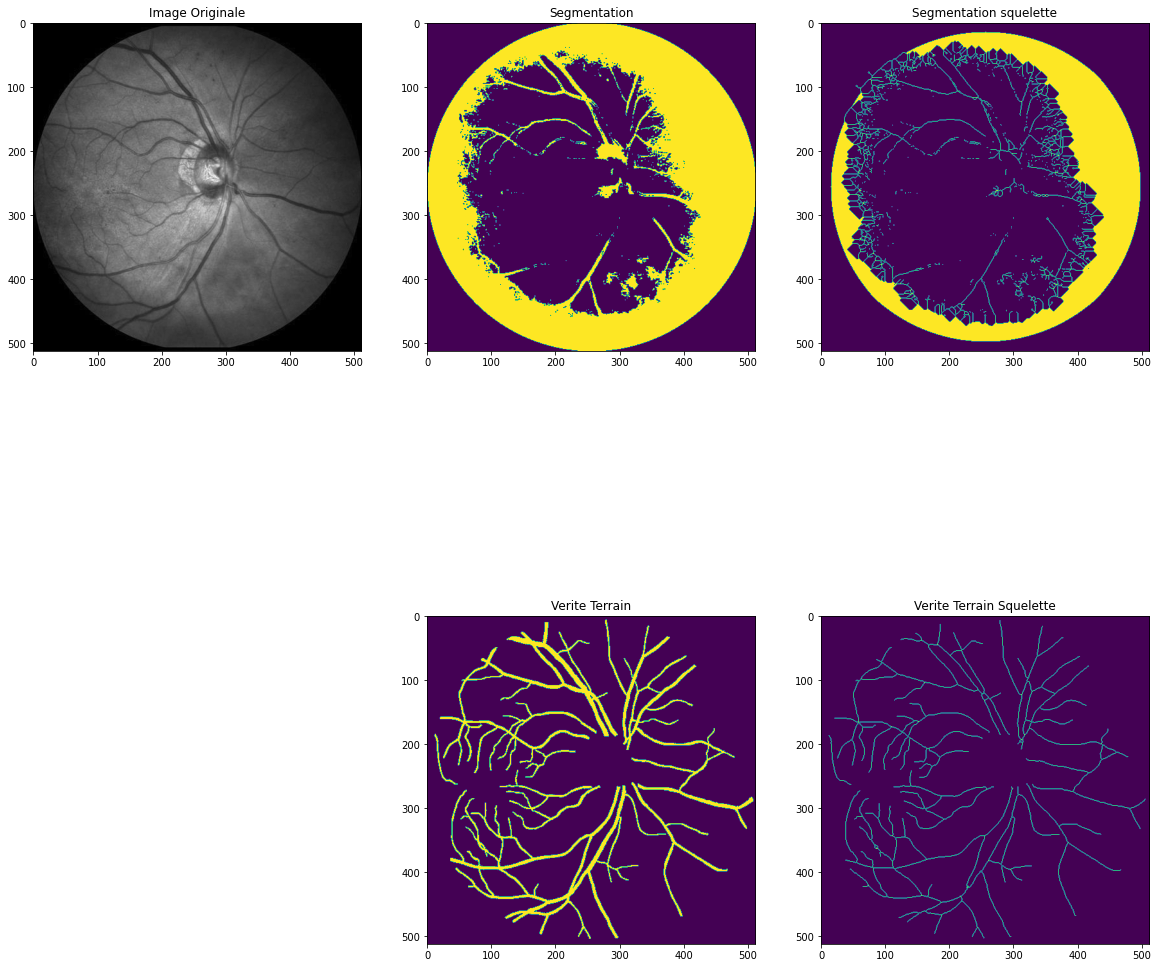

In [280]:
#Ouvrir l'image Verite Terrain en booleen
img_GT =  np.asarray(Image.open(TD_DIR + './images_IOSTAR/GT_28.png')).astype(np.bool_)
img_out = my_segmentation(img,img_mask,80) # Shitty given segmentation to test

#Evaluation test basique
ACCU, RECALL, img_out_skel, GT_skel = evaluate(img_out, img_GT)
print('Accuracy =', ACCU,', Recall =', RECALL)

plt.figure(figsize=(20,20))

plt.subplot(231)
plt.imshow(img,cmap = 'gray')
plt.title('Image Originale')

plt.subplot(232)
plt.imshow(img_out)
plt.title('Segmentation')

plt.subplot(233)
plt.imshow(img_out_skel)
plt.title('Segmentation squelette')

plt.subplot(235)
plt.imshow(img_GT)
plt.title('Verite Terrain')

plt.subplot(236)
plt.imshow(GT_skel)
plt.title('Verite Terrain Squelette')
plt.show()

# Definition de fonctions


In [281]:
def nivellementMixte(Image,Image_ref) :
    Image.astype(np.uint8)
    Image_ref.astype(np.uint8)
    
    maskPlus = Image > Image_ref
    maskMoins = Image <= Image_ref
    ImageMoins = copy.deepcopy(Image)
    ImagePlus = copy.deepcopy(Image)
    
    ImageMoins[maskPlus] = 0
    ImagePlus[maskMoins] = 255

    nMoins = reconstruction(ImageMoins,copy.deepcopy(Image_ref))
    nPlus = complementaire(reconstruction(complementaire(ImagePlus),complementaire(Image_ref)))
    nMoins[maskPlus] = 0
    nPlus[maskMoins] = 0
    return nMoins+nPlus
def func(lap, mode=0) :
    if mode == 0 :
        return 1 if lap > 0 else 0;
    return 1 if lap < 0 else 0;
def detec_contours(img,se,seuil=50) :

    imLap = LapMorph(img,se)
    vfunc1 = np.vectorize(func)
    vfunc2 = np.vectorize(lambda x,s : 1 if x > s else 0)

    im1 = vfunc1(imLap)
    im2 = vfunc1(imLap,1)

    im1.astype(np.uint8)
    im2.astype(np.uint8)

    im1 = dilation(im1)
    res0 = im1*im2

    imGrad = GradMorph(img,se)
    Gs = vfunc2(imGrad,seuil)
    Gs.astype(np.uint8)

    contours = res0*Gs

    return 255*contours

def alterne(img,elements) :
    for se in elements :
        img = reconstruction(opening(img,se),img)
        img = complementaire(reconstruction(complementaire(closing(img,se)),complementaire(img)))
    return img

In [282]:

def granulometrie(img,se,n) :
    for i in range(n):
        img = opening(closing(img,se),se)
    return img
def granulometrie_inv(img,se,n) :
    for i in range(n):
        img = closing(opening(img,se),se)
    return img

def essai(img,se,n) :
    for i in range(n) :
        img = erosion(dilation(img,se),se)
    return img
def hysteresis(img,se_b,se_h) :
    seuil_bas = img < se_b
    seuil_haut = img < se_h
    img3 = reconstruction(seuil_bas.astype(np.uint8),seuil_haut.astype(np.uint8))
    return img3

def GradInt(img,se) :
    return img - erosion(img,se)
def complementaire(img) :
    return 255 - img
def GradExt(img,se) :
    return dilation(img,se) - img

def GradMorph(img,se) :
    return dilation(img,se) - erosion(img,se)
def LapMorph(img,se) :
    return GradExt(img,se).astype(np.float16) - GradInt(img,se).astype(np.float16)

def fermeture_reco(img,se) :
    img = complementaire(reconstruction(complementaire(closing(img,se)),complementaire(img)))
    return img

def ouverture_reco(img,se) :
    img = reconstruction(opening(img,se),img)
    return img

# **Début de notre proposition**

nous commencons par normaliser l'image et nous aumgentons le contraste afin de mettre en valeur les vaisseaux sanguins.
puis : 
- on fait un top hat pour isoler les vaisseaux
- on essai de detecter les contours via un gradient (interieur) et on rebouche ces vaisseaux depuis leurs parois (l'image apparait moins bruitée et les vaisseaux isolés)
- on fait des ouvertures par reconstruction avec un element structurant croissant pour supprimer les petites composantes (graduellement)

- on refait une ouverture et une fermeture par reconstruction pour filter un peu plus

- on inverse l'image (les vaisseaux doivent etre en blanc)

- on tente de recombiner l'image avec un top hat initial pour accentuer la demarquation des vaisseaux puis on applique un filtre alterné sequentiel d'ouverture et fermeture par reconstruction pour lisser le resultat

- on garde l'image obtenue qui pourra reservir plus tard

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


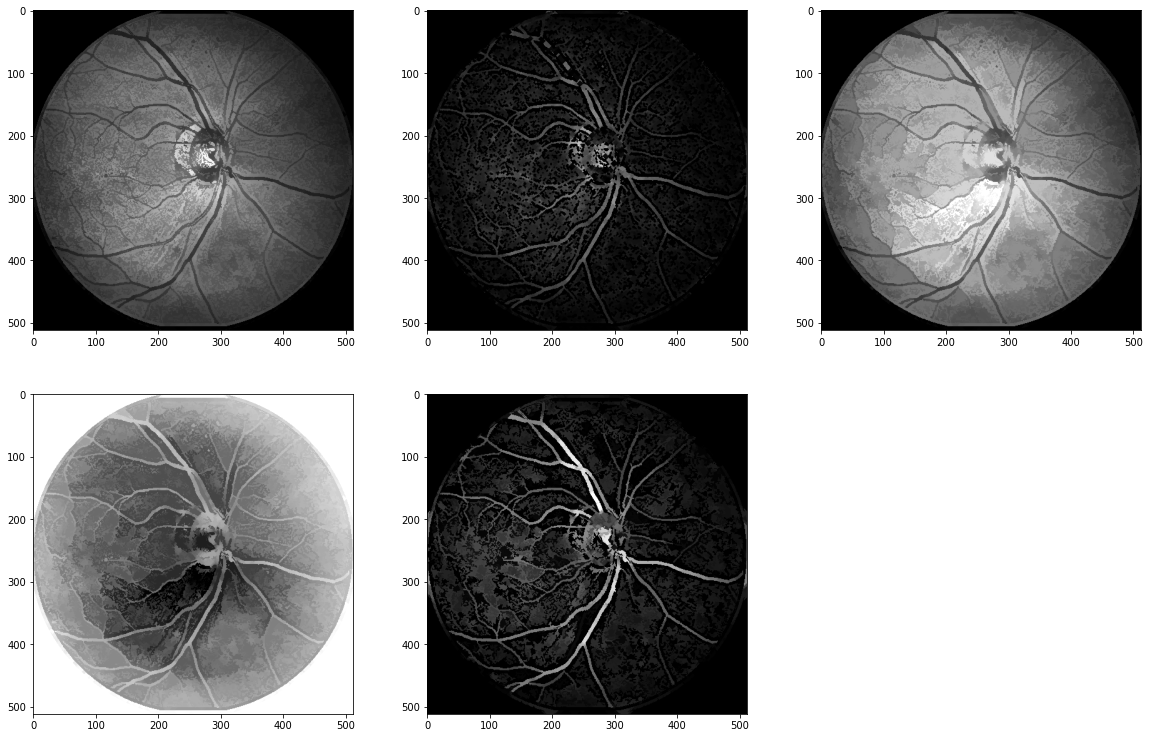

In [283]:
plt.figure(figsize=(20,20))
se4 = diamond(4)
plt.subplot(331)
img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
img2 = enhance_contrast_percentile(img,diamond(5),mask=img_mask)
plt.imshow(img2,cmap='gray')

plt.subplot(332)

new_img = black_tophat(img2,se4)
new_img = GradInt(new_img,diamond(4))

new_img = reconstruction(new_img.astype(np.uint8),closing(new_img.astype(np.uint8),disk(1)))
plt.imshow(new_img,cmap = "gray")

plt.subplot(333)
for i in range(1,6) :
    new_img = reconstruction(opening(img2.astype(np.uint8),disk(i)),img2.astype(np.uint8))

plt.imshow(new_img,cmap='gray')



plt.subplot(334)
new_img = complementaire(new_img)
plt.imshow(new_img,cmap='gray')

plt.subplot(335)
new_img = reconstruction(opening(new_img.astype(np.uint8),diamond(1)),new_img.astype(np.uint8))
new_img = new_img * black_tophat(img2,diamond(5))
new_img = alterne(new_img,[disk(i) for i in range(2,4)])
plt.imshow(new_img,cmap='gray')

img_save0 = copy.deepcopy(new_img)

# Essai de réduction de bruit

Le principal probleme reste d'enlever le bruit de fond apres le tophat. Ici nous essayons de le traiter en creant plusieurs traitement differents et en combinant les images finales

- premier traitement : on reprend la base de toute à l'heure en faisant un traitement plus simple (tophat + reconstruction de la fermeture (elimine les petites composantes) +seuillage par hysteresis)

- deuxieme traitement, on separe les vaisseaux du reste en commencant par un tophat puis un gradient (pour avoir les contours) puis un filtre alterné (ouverture et fermeture par reconstruction). On la combine a la derniere image en faisant une moyenne pondérée (renforce les vaisseaux) 

- troisieme traitement : en partant de l'image initiale on fait un gradient avec un petit element structurant pour aussi detourer le bruit puis on le seuil et on mutiplie cette image avec la precedente pour isoler les vaisseaux plus nettement


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


Accuracy = 0.7484239558707644 , Recall = 0.5386360414008223


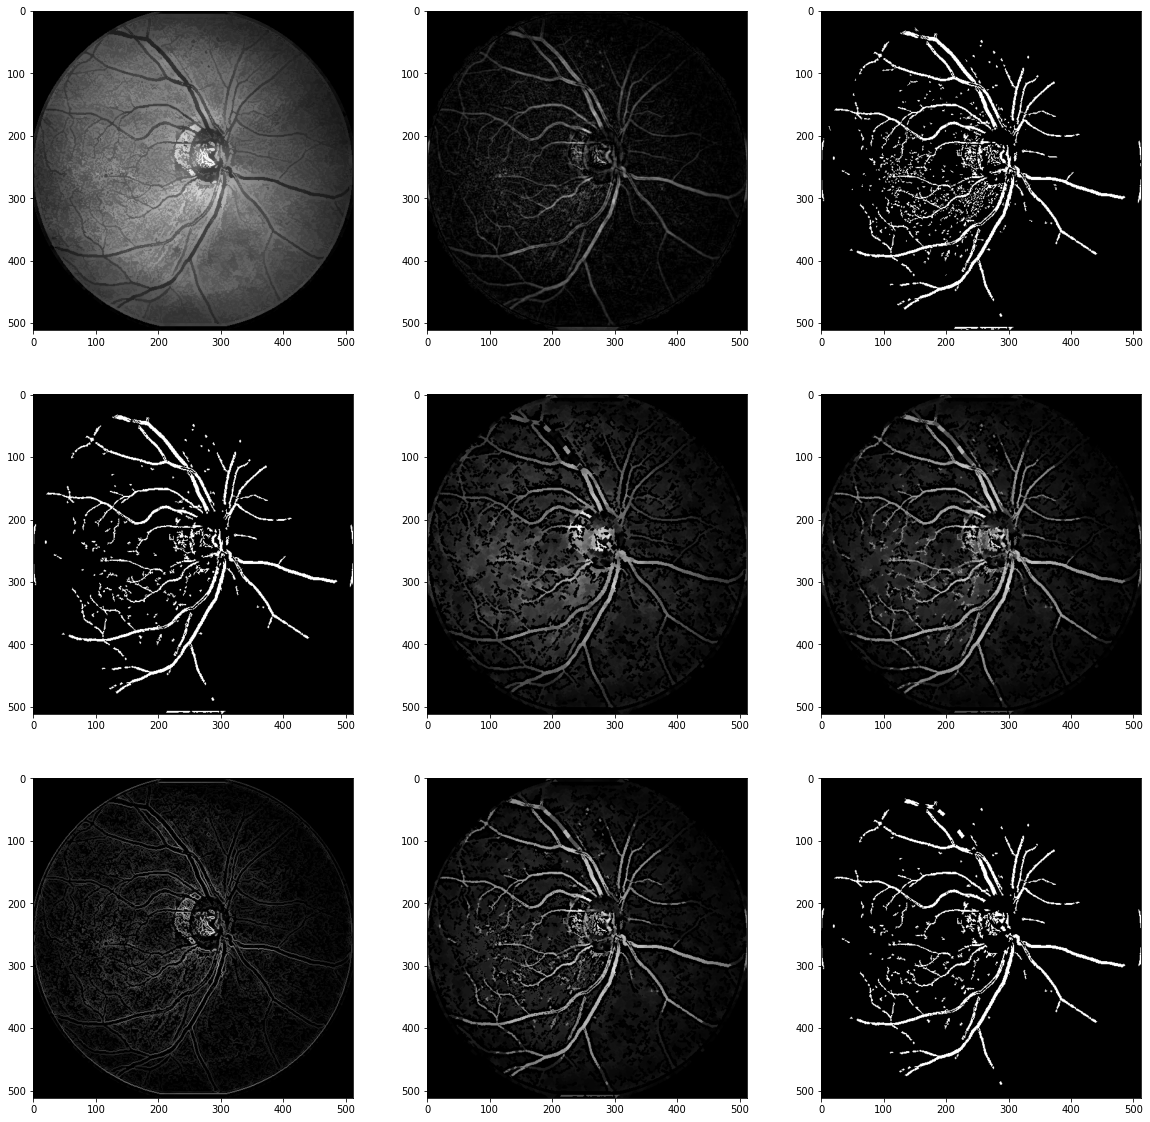

In [284]:
#Essai reduction de bruit
new_img = essai(img,se4,10)
img_out = my_segmentation(new_img,img_mask,75)

plt.figure(figsize=(20,20))

plt.subplot(331)
plt.imshow(img2,cmap='gray')

plt.subplot(332)
new_img = black_tophat(img,diamond(5))
plt.imshow(new_img,cmap = 'gray')

plt.subplot(333)
new_img = complementaire(reconstruction(complementaire(closing(new_img,disk(2))),complementaire(new_img)))
new_img = enhance_contrast_percentile(new_img,disk(2))

new_img = hysteresis(new_img,2,20)
new_img = complementaire(new_img*255)
plt.imshow(new_img,cmap='gray')

plt.subplot(334)
new_img = ouverture_reco(new_img,disk(1))
img_save1 = copy.deepcopy(new_img)

plt.imshow(new_img,cmap='gray')

plt.subplot(335)

img3 = black_tophat(img2,se4)
img3 = GradInt(img3,diamond(6))

img3 = reconstruction(img3.astype(np.uint8),closing(img3.astype(np.uint8),disk(1)))
img3 = alterne(img3 , [disk(i) for i in range(1,3)])
plt.imshow(img3,cmap = "gray")

plt.subplot(336)
img3 = (5*img3+new_img)/6
plt.imshow(img3,cmap='gray')

plt.subplot(337)
img4 = GradInt(img2,disk(2))#detection des petits contours
plt.imshow(img4,cmap = 'gray')

plt.subplot(338)
img4 = hysteresis(img4,3,30)
img4 = img4*img3
plt.imshow(img4,cmap = 'gray')
plt.subplot(339)
img4 = complementaire(hysteresis(img4,5,60))
img4 = ouverture_reco(img4,disk(1))
#img4 = essai(img4,disk(2),2)

plt.imshow(img4,cmap = 'gray')
img_save2 = copy.deepcopy(img4)


ACCU, RECALL, img_out_skel, GT_skel = evaluate((img4-254)*255 > 50, img_GT)
print('Accuracy =', ACCU,', Recall =', RECALL)


## ESSAIS par d'autres idées

- on multiplie le tophat avec l'image initiale (renforce les vaisseaux sans tout eliminer)

- on applique un gradient pour isoler les vaisseaux et on la conbine avec des images précédentes (permet de progresser continuellement) puis on applique un filtre alterné d'ouvertures et fermetures par reconstruction

- on seuil (seuil minimal seulement pour transformer l'image en 0 ou 1) puis on dilate legerement les vaisseaux pour retrouver des connexions avant d'appliquer de nouveau un filtre alterné



Accuracy = 0.7498188843274571 , Recall = 0.49648225135913016


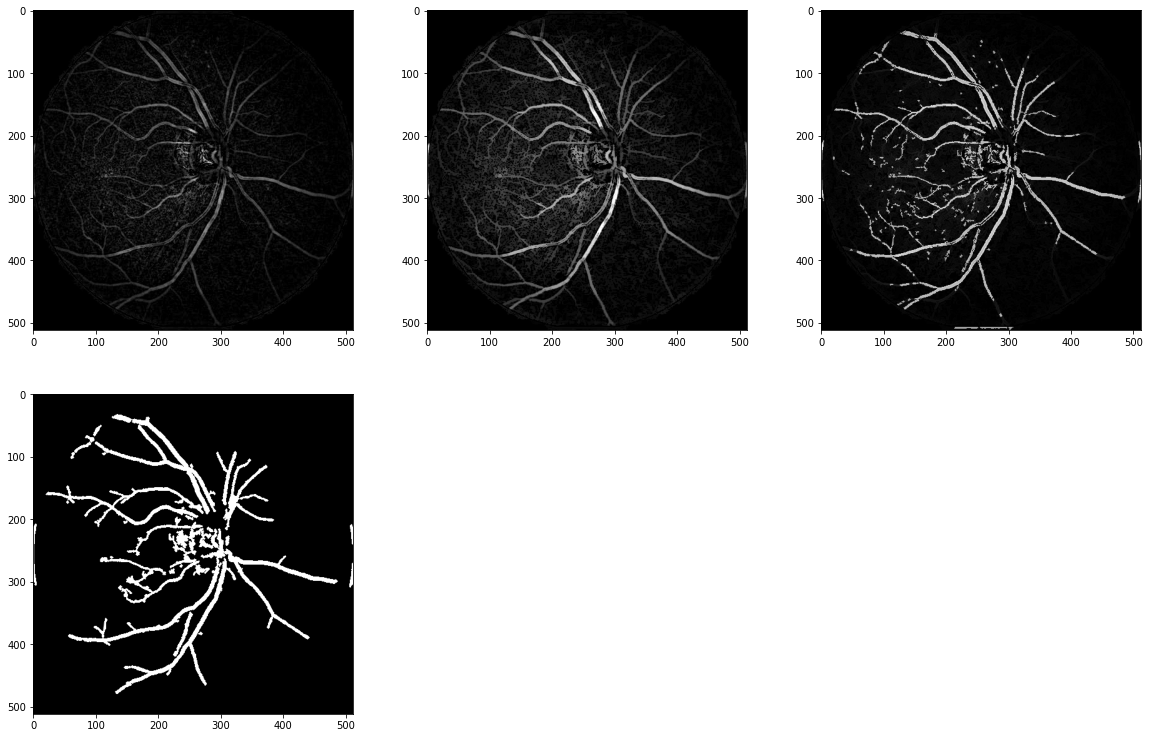

In [285]:

plt.figure(figsize=(20,20))

plt.subplot(331)
image = complementaire(img)
image = image*black_tophat(img,disk(4))
plt.imshow(image,cmap = 'gray')

plt.subplot(332)
image = image*img4/255
image = ouverture_reco(image,disk(2))
plt.imshow(image,cmap = 'gray')

plt.subplot(333)
image = (4*GradInt(image,disk(2))+img_save1)/5
image = alterne(image,[diamond(i) for i in range(1,2)])

plt.imshow(image,cmap = 'gray')

plt.subplot(334)

image = complementaire(255*hysteresis(image,6,45))
image = dilation(image,disk(1))
image = alterne(image,[disk(i) for i in range(1,4)])
plt.imshow(image,cmap = 'gray')




img_save3 = copy.deepcopy(image)

ACCU, RECALL, img_out_skel, GT_skel = evaluate(image > 50, img_GT)
print('Accuracy =', ACCU,', Recall =', RECALL)




##ESSAI FINAL

- on repart du top hat qu'on erode puis dilate afin de supprimer les petites composantes puis on rapplique un tophat dessus

- on fait une ouverture par reconstruction dessus pour eliminer les petites composantes en gardant les composantes connexes puis on applique une fermeture pour boucher les trous

- on applique un nivellement mixe avec l'image dont on a aumenté de contraste (pour isoler les vaisseaux)

- on applique une fermeture par reconstruction sur une granulometrie croissante afin de boucher les trous puis on fait un nouveau seuillage par hysteresis

- on combine ça avec les images précédentes (moyenne pondérée)

- on dilate les vaisseaux pour compenser la perte de volume


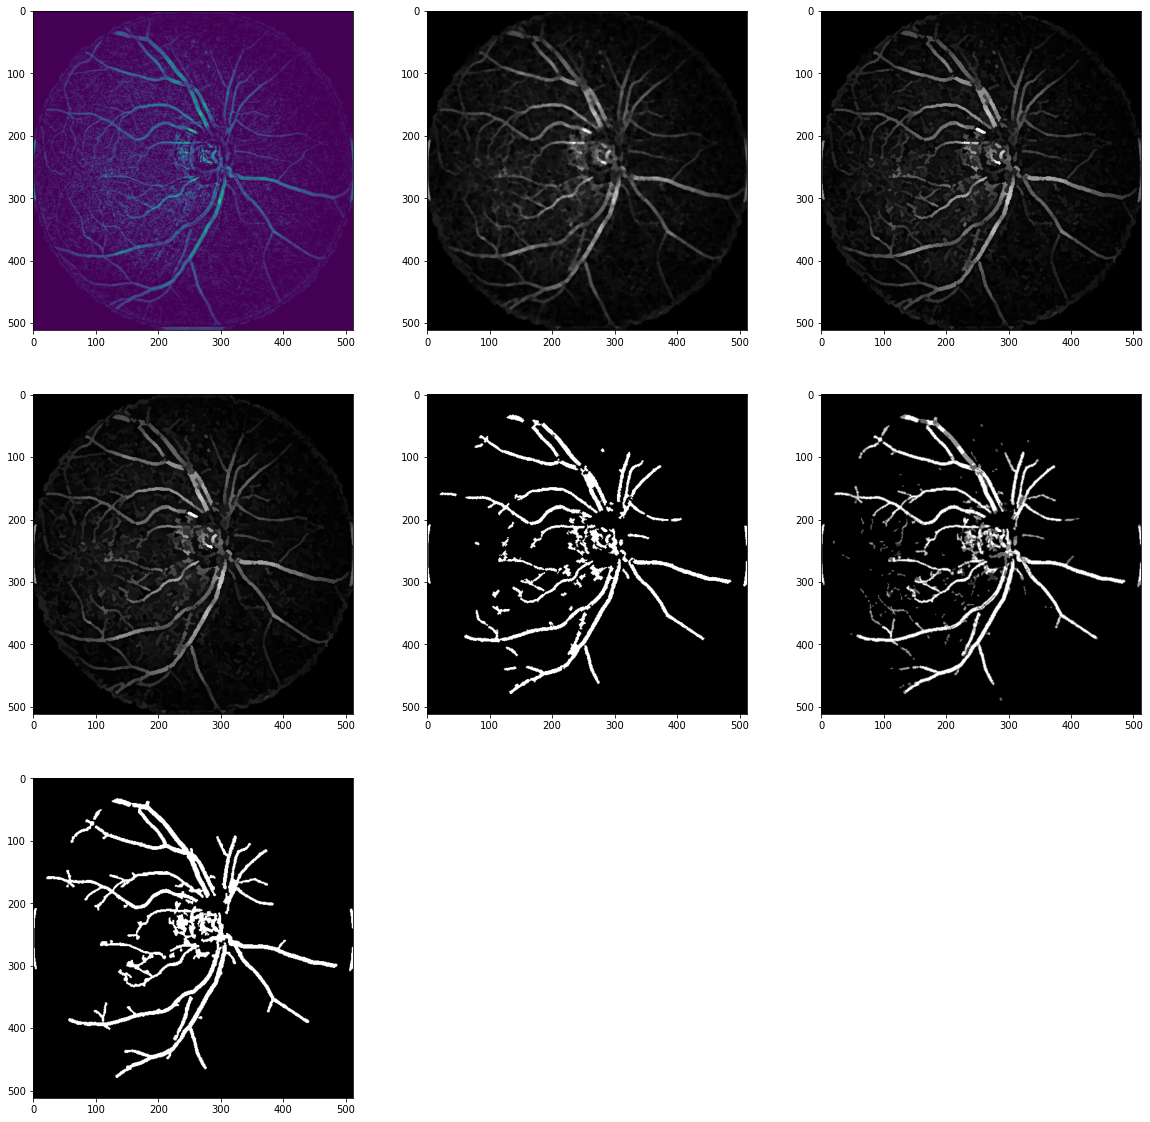

In [286]:
se4 = diamond(5)
new_img = essai(img,se4,10)
img_out = my_segmentation(new_img,img_mask,75)

plt.figure(figsize=(20,20))


plt.subplot(331)
new_img = black_tophat(img*255,se4)
plt.imshow(new_img)

plt.subplot(332)
new_img = nivellementMixte(new_img,dilation(new_img,disk(1)))
new_img = white_tophat(new_img,diamond(5))

new_img = reconstruction(opening(new_img.astype(np.uint8),np.array([[1,1,1,1,1]])),new_img.astype(np.uint8))
new_img = closing(new_img,diamond(2))

plt.imshow(new_img,cmap='gray')


plt.subplot(333)
new_img = new_img*255/np.max(new_img)
new_img = new_img.astype(np.uint8)
new_img = nivellementMixte(new_img,enhance_contrast_percentile(new_img,disk(4)))
plt.imshow(new_img,cmap='gray')

plt.subplot(334)
new_img = alterne(new_img,[diamond(i) for i in range(1,3)])

plt.imshow(new_img,cmap='gray')

plt.subplot(335)
new_img = complementaire(hysteresis(new_img,25,60))
plt.imshow(new_img,cmap='gray')

plt.subplot(336)
new_img = (new_img-254)*255
new_img = (2*img_save3+2*(img_save2-254)*255+new_img)/5
new_img = nivellementMixte(new_img, median(new_img,disk(1)))
plt.imshow(new_img,cmap='gray')

plt.subplot(337)
new_img = ouverture_reco(new_img,disk(3))
new_img = ouverture_reco(new_img, disk(2))


new_img = complementaire(255*hysteresis(new_img,50,87))

plt.imshow(new_img,cmap='gray')



new_img.astype(np.uint8)
img_out = (img_mask & (new_img == 255))
img_out = (img_mask & (img_out == img_GT)) 



Accuracy = 0.7627118644067796 , Recall = 0.48968653565047915


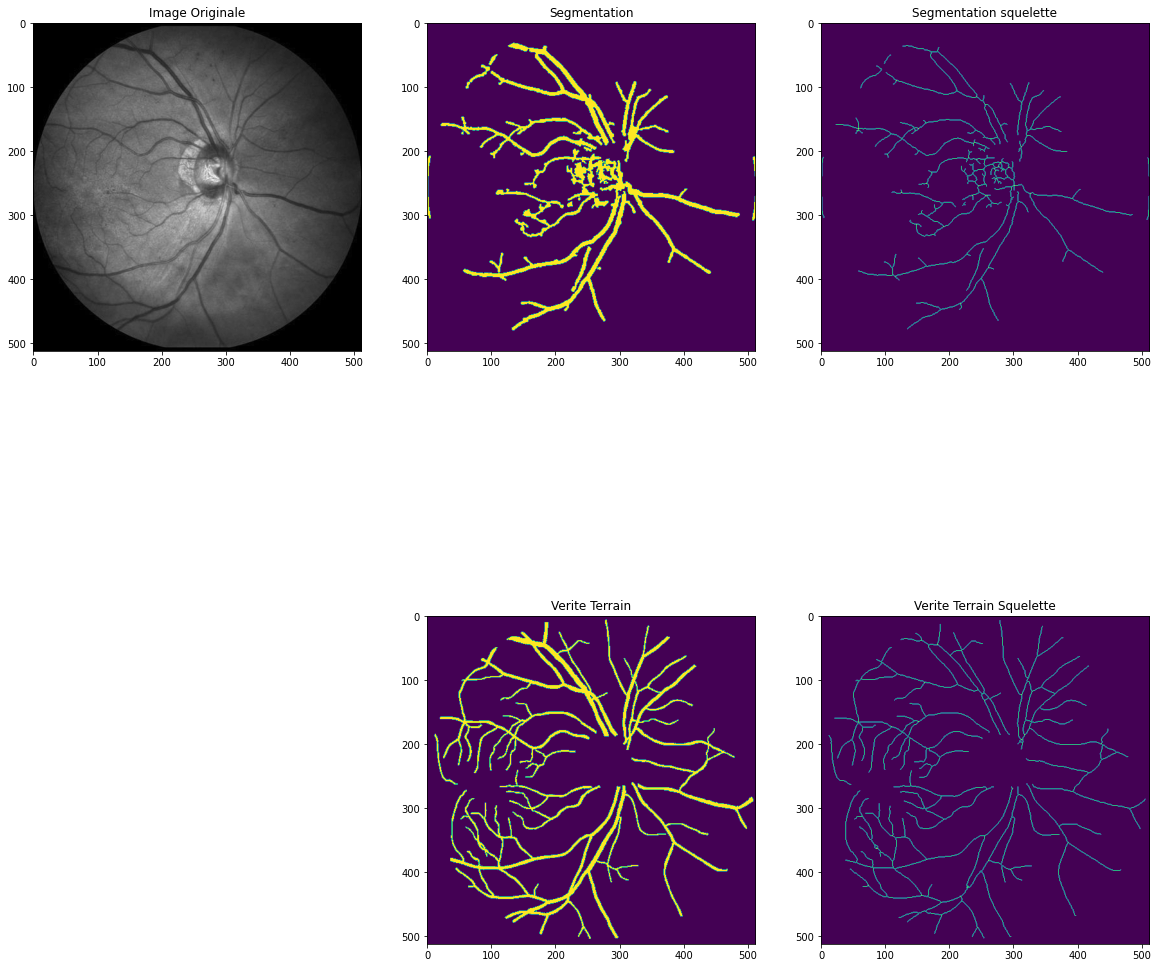

In [287]:
#Ouvrir l'image Verite Terrain en booleen
ACCU, RECALL, img_out_skel, GT_skel = evaluate(new_img > 50, img_GT)
print('Accuracy =', ACCU,', Recall =', RECALL)

plt.figure(figsize=(20,20))
plt.subplot(231)
plt.imshow(img,cmap = 'gray')
plt.title('Image Originale')
plt.subplot(232)
plt.imshow(new_img)
plt.title('Segmentation')
plt.subplot(233)
plt.imshow(img_out_skel)
plt.title('Segmentation squelette')
plt.subplot(235)
plt.imshow(img_GT)
plt.title('Verite Terrain')
plt.subplot(236)
plt.imshow(GT_skel)
plt.title('Verite Terrain Squelette')
plt.show()